## Topic : Progression of Parkinson Disease 

#### Group Members: 
   ###### Jamilya Seisembekova
   ###### Rayan Karout 
   ###### Juan David Useche
   ###### Rim Boughanmi

# Phase I : Data Cleaning 

### 1- Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
np.random.seed(3) 




###  2- Importing all files

In [2]:
Peptides_data = pd.read_csv('train_peptides.csv')
Proteins_data = pd.read_csv('train_proteins.csv')
supplemental_clinical_data = pd.read_csv('supplemental_clinical_data.csv')
train_clinical_data = pd.read_csv('train_clinical_data.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'train_peptides.csv'

### 3- Discovering and cleaning Train Clinical Data 

In [ ]:
train_clinical_data.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [ ]:
train_clinical_data.isnull().sum()


visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [ ]:
train_clinical_data.shape

(2615, 8)

Filling missing values in the updrs_1, updrs_2, and updrs_3 columns involved a process that ensured accurate imputation while considering each patient's data sequence. The function fill_missing_updrs123() was created to systematically handle missing values within patient groups. This function first performed forward-fill and backward-fill operations within each patient's data to replace missing values with the nearest available measurements before and after. By incorporating this function for each UPDRS column, we were able to maintain data integrity by utilizing the available information while accounting for temporal sequencing within patients' visits. The temporary columns created during this process were then dropped to maintain the cleanliness and organization of the data. However a different approach would be implemented for updrs_4

In [ ]:


def fill_missing_updrs_123(data, updrs_column):
    # Create a temporary filled column within each patient group
    filled_column = f'{updrs_column}_filled'
    data[filled_column] = data.groupby('patient_id')[updrs_column].ffill()
    data[filled_column] = data.groupby('patient_id')[filled_column].bfill()
    data[updrs_column] = data[updrs_column].fillna(data[filled_column])
    
    # Dropping the temporary filled column
    data.drop(columns=filled_column, inplace=True)
    return data

# Filling missing values for UPDRS_1
train_clinical_data = fill_missing_updrs_123(train_clinical_data, 'updrs_1')

# Filling missing values for UPDRS_2
train_clinical_data = fill_missing_updrs_123(train_clinical_data, 'updrs_2')

# Filling missing values for UPDRS_3
train_clinical_data = fill_missing_updrs_123(train_clinical_data, 'updrs_3')


In [ ]:
train_clinical_data.isnull().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   0
updrs_2                                   0
updrs_3                                   0
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

###### In addressing missing values within the updrs_4 column, a two-fold strategy was implemented. First, a binary indicator column, 'updrs_4_missing', was created to distinctly mark the initially missing values. This indicator serves as a valuable flag, indicating whether the patient's updrs_4 level was genuinely absent or started as 0. Subsequently, the missing values in updrs_4 were replaced with zeros. Even in cases where a patient's updrs_4 level might be naturally 0, the 'updrs_4_missing' column distinguishes between inherent zero levels and missing data. This dual approach not only addresses the missing values but also acknowledges both inherent zero levels and absent measurements.

In [ ]:

# Creating a binary indicator column for missing UPDRS_4 values
train_clinical_data['updrs_4_missing'] = train_clinical_data['updrs_4'].isnull().astype(int)

# Filling missing values in UPDRS_4 with zeros
train_clinical_data['updrs_4'] = train_clinical_data['updrs_4'].fillna(0)


In [ ]:
train_clinical_data['clinical_state_on_medication'] =  train_clinical_data['upd23b_clinical_state_on_medication']

In [ ]:

mode_per_patient = train_clinical_data.groupby('patient_id')['clinical_state_on_medication'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Merging the mode values back to the original dataframe
train_clinical_data = pd.merge(train_clinical_data, mode_per_patient, on='patient_id', how='left', suffixes=('', '_mode'))

# Filling missing values in 'clinical_state_on_medication' with the calculated modes
train_clinical_data['clinical_state_on_medication'] = train_clinical_data['clinical_state_on_medication'].fillna(train_clinical_data['clinical_state_on_medication_mode'])

# Dropping the temporary mode column
train_clinical_data.drop(columns='clinical_state_on_medication_mode', inplace=True)


In [ ]:
del(train_clinical_data["upd23b_clinical_state_on_medication"])

In [ ]:
train_clinical_data.isnull().sum()

visit_id                          0
patient_id                        0
visit_month                       0
updrs_1                           0
updrs_2                           0
updrs_3                           0
updrs_4                           0
updrs_4_missing                   0
clinical_state_on_medication    732
dtype: int64

###### filling missing values with 'unknown'

In [ ]:
train_clinical_data['clinical_state_on_medication'].fillna('Unknown', inplace=True)


In [ ]:
train_clinical_data.isna().sum()

visit_id                        0
patient_id                      0
visit_month                     0
updrs_1                         0
updrs_2                         0
updrs_3                         0
updrs_4                         0
updrs_4_missing                 0
clinical_state_on_medication    0
dtype: int64

In [ ]:
train_clinical_data.shape

(2615, 9)

In [ ]:
train_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On
1,55_3,55,3,10.0,7.0,25.0,0.0,1,On
2,55_6,55,6,8.0,10.0,34.0,0.0,1,On
3,55_9,55,9,8.0,9.0,30.0,0.0,0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,0,On


### 4- Discovering and cleaning Supplemental Clinical Data 


 supplemental_clinical_data is same as train_clinical_data so we will be following the same claning strategy before we merge them into one data frame

In [ ]:
supplemental_clinical_data.head()


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,On
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN


In [ ]:
supplemental_clinical_data.isnull().sum()


visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                 213
updrs_2                                 214
updrs_3                                   5
updrs_4                                 928
upd23b_clinical_state_on_medication    1101
dtype: int64

In [ ]:

# Filling missing values for UPDRS_1
supplemental_clinical_data = fill_missing_updrs_123(supplemental_clinical_data, 'updrs_1')

# Filling missing values for UPDRS_2
supplemental_clinical_data = fill_missing_updrs_123(supplemental_clinical_data, 'updrs_2')

# Filling missing values for UPDRS_3
supplemental_clinical_data = fill_missing_updrs_123(supplemental_clinical_data, 'updrs_3')


In [ ]:
supplemental_clinical_data.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                  96
updrs_2                                  96
updrs_3                                   3
updrs_4                                 928
upd23b_clinical_state_on_medication    1101
dtype: int64

In [ ]:
# Displaying the rows with missing values in 'clinical_state_on_medication'
missing_values_mask = supplemental_clinical_data['updrs_1'].isnull()
rows_with_missing_values = supplemental_clinical_data[missing_values_mask]
print(rows_with_missing_values)


     visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
4       155_0         155            0      NaN      NaN      0.0      NaN   
27      889_0         889            0      NaN      NaN      0.0      NaN   
65     1663_0        1663            0      NaN      NaN      0.0      NaN   
85     2222_0        2222            0      NaN      NaN      0.0      NaN   
86     2331_0        2331            0      NaN      NaN      1.0      NaN   
...       ...         ...          ...      ...      ...      ...      ...   
2127  63278_0       63278            0      NaN      NaN      4.0      NaN   
2130  63335_0       63335            0      NaN      NaN      7.0      NaN   
2136  63479_0       63479            0      NaN      NaN      6.0      NaN   
2148  63774_0       63774            0      NaN      NaN      0.0      NaN   
2218  65382_0       65382            0      NaN      NaN      0.0      NaN   

     upd23b_clinical_state_on_medication  
4                   

###### these patients have most of their updrs level missing so it would be more accurate to just drop their correspening rows

In [ ]:
supplemental_clinical_data.dropna(subset=['updrs_1', 'updrs_2', 'updrs_3'], inplace=True)


In [ ]:
supplemental_clinical_data.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   0
updrs_2                                   0
updrs_3                                   0
updrs_4                                 832
upd23b_clinical_state_on_medication    1004
dtype: int64

In [ ]:
supplemental_clinical_data['updrs_4_missing'] = supplemental_clinical_data['updrs_4'].isnull().astype(int)
supplemental_clinical_data['updrs_4'] = supplemental_clinical_data['updrs_4'].fillna(0)

In [ ]:
supplemental_clinical_data.isna().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   0
updrs_2                                   0
updrs_3                                   0
updrs_4                                   0
upd23b_clinical_state_on_medication    1004
updrs_4_missing                           0
dtype: int64

In [ ]:
supplemental_clinical_data['clinical_state_on_medication'] =  supplemental_clinical_data['upd23b_clinical_state_on_medication']

In [ ]:
del(supplemental_clinical_data["upd23b_clinical_state_on_medication"])

In [ ]:

mode_per_patient1 = supplemental_clinical_data.groupby('patient_id')['clinical_state_on_medication'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Merging the mode values back to the original dataframe
supplemental_clinical_data = pd.merge(supplemental_clinical_data, mode_per_patient1, on='patient_id', how='left', suffixes=('', '_mode'))

# Filling missing values in 'clinical_state_on_medication' with the calculated modes
supplemental_clinical_data['clinical_state_on_medication'] = supplemental_clinical_data['clinical_state_on_medication'].fillna(supplemental_clinical_data['clinical_state_on_medication_mode'])

# Dropping the temporary mode column
supplemental_clinical_data.drop(columns='clinical_state_on_medication_mode', inplace=True)


In [ ]:
supplemental_clinical_data.isna().sum()

visit_id                          0
patient_id                        0
visit_month                       0
updrs_1                           0
updrs_2                           0
updrs_3                           0
updrs_4                           0
updrs_4_missing                   0
clinical_state_on_medication    469
dtype: int64

In [ ]:
supplemental_clinical_data['clinical_state_on_medication'].fillna('Unknown', inplace=True)


In [ ]:
supplemental_clinical_data.isna().sum()

visit_id                        0
patient_id                      0
visit_month                     0
updrs_1                         0
updrs_2                         0
updrs_3                         0
updrs_4                         0
updrs_4_missing                 0
clinical_state_on_medication    0
dtype: int64

In [ ]:
supplemental_clinical_data.shape

(2125, 9)

### 5- Merging Train Clinical Data and Supplemental Clinical Data

###### Here we are going to combine both of our files (train_clinical_data and suppelemental_clinical_data) into one file

In [ ]:
Final_clinical_data = pd.concat([train_clinical_data, supplemental_clinical_data])
Final_clinical_data.drop_duplicates(keep=False, inplace=True)

In [ ]:
Final_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On
1,55_3,55,3,10.0,7.0,25.0,0.0,1,On
2,55_6,55,6,8.0,10.0,34.0,0.0,1,On
3,55_9,55,9,8.0,9.0,30.0,0.0,0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,0,On


In [ ]:
Final_clinical_data.shape

(4740, 9)

In [ ]:
Final_clinical_data.duplicated().any()

False

In [ ]:
Final_clinical_data.isna().sum()

visit_id                        0
patient_id                      0
visit_month                     0
updrs_1                         0
updrs_2                         0
updrs_3                         0
updrs_4                         0
updrs_4_missing                 0
clinical_state_on_medication    0
dtype: int64

###### The UPDRS (Unified Parkinson's Disease Rating Scale) is divided into four parts (1, 2, 3, and 4 which are updrs_1, updrs_2,updrs_3,updrs_4 respectively from our datasaet), each focusing on different aspects of Parkinson's disease. After thorough checkouts we unfodled that for research or clinical purposes, some studies or clinicians may use a total UPDRS score by summing the scores across all parts to get an overall measure of disease severity hence(Total_UPDRS). This total score would consider both motor and non-motor aspects of Parkinson's disease.

In [ ]:


Final_clinical_data['Total_UPDRS'] = Final_clinical_data[['updrs_1','updrs_2','updrs_3', 'updrs_4']].sum(axis=1)

In [ ]:
Final_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On,31.0
1,55_3,55,3,10.0,7.0,25.0,0.0,1,On,42.0
2,55_6,55,6,8.0,10.0,34.0,0.0,1,On,52.0
3,55_9,55,9,8.0,9.0,30.0,0.0,0,On,47.0
4,55_12,55,12,10.0,10.0,41.0,0.0,0,On,61.0


###### Our first dataframe is clean and set for usage

### 6- Discovering Train Peptides 

In [ ]:
Peptides_data.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [ ]:
Peptides_data.shape

(981834, 6)

In [ ]:

summed_peptide_data = Peptides_data.groupby(['visit_id'])['PeptideAbundance'].sum().reset_index()


In [ ]:
summed_peptide_data

,visit_id,PeptideAbundance
0,10053_0,4.713352e+08
1,10053_12,4.666371e+08
2,10053_18,5.220732e+08
3,10138_12,6.515605e+08
4,10138_24,6.720870e+08
...,...,...
1108,8699_24,6.618368e+08
1109,942_12,5.540194e+08
1110,942_24,5.677032e+08
1111,942_48,5.979831e+08


In [ ]:
from scipy import stats



In [ ]:
Peptides_data['UniProt'].value_counts() #227 UniProt
Peptides_data['Peptide'].value_counts() #968 Peptide
Peptides_data['PeptideAbundance'].value_counts()

PeptideAbundance
127056.0    10
144004.0    10
109591.0    10
103890.0     9
116278.0     9
            ..
21198.0      1
62987.2      1
182618.0     1
30224.1      1
12825.9      1
Name: count, Length: 738931, dtype: int64

In [ ]:
Peptides_data.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [ ]:
Peptides = Peptides_data.groupby('visit_id')['PeptideAbundance'].sum().reset_index()
Peptides

,visit_id,PeptideAbundance
0,10053_0,4.713352e+08
1,10053_12,4.666371e+08
2,10053_18,5.220732e+08
3,10138_12,6.515605e+08
4,10138_24,6.720870e+08
...,...,...
1108,8699_24,6.618368e+08
1109,942_12,5.540194e+08
1110,942_24,5.677032e+08
1111,942_48,5.979831e+08


In [ ]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
Peptide_Abundnace_Reshape = Peptides['PeptideAbundance'].values.reshape(-1, 1)
Peptides['Peptide Abundance Standardized'] = Scaler.fit_transform(Peptide_Abundnace_Reshape)

In [ ]:
Peptides

,visit_id,PeptideAbundance,Peptide Abundance Standardized
0,10053_0,4.713352e+08,-1.035157
1,10053_12,4.666371e+08,-1.085926
2,10053_18,5.220732e+08,-0.486862
3,10138_12,6.515605e+08,0.912430
4,10138_24,6.720870e+08,1.134248
...,...,...,...
1108,8699_24,6.618368e+08,1.023480
1109,942_12,5.540194e+08,-0.141637
1110,942_24,5.677032e+08,0.006235
1111,942_48,5.979831e+08,0.333452


Our second dataset is clean and set for usage 

In [ ]:
#Test : 
Total_PeptideAbu  = Peptides['PeptideAbundance'].sum()
Total_PeptideAbu_std  = Peptides['Peptide Abundance Standardized'].sum()

print(Total_PeptideAbu); print(Total_PeptideAbu_std)

631211501725.2501
-4.565237077258644e-13


### 7 - Discovering Train Protein

In [ ]:
Proteins_data.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [ ]:
Proteins_data.shape

(232741, 5)

In [ ]:

Proteins = Proteins_data.groupby(['visit_id'])['NPX'].sum().reset_index()


In [ ]:

Proteins.head()

,visit_id,NPX
0,10053_0,4.713356e+08
1,10053_12,4.666370e+08
2,10053_18,5.220732e+08
3,10138_12,6.515605e+08
4,10138_24,6.720872e+08


In [ ]:
from sklearn.preprocessing import StandardScaler
Proteins= pd.DataFrame(Proteins)
scale= StandardScaler()
X_data = Proteins[['NPX']]
Proteins['Standardized_NPX'] = scale.fit_transform(X_data)
Proteins

,visit_id,NPX,Standardized_NPX
0,10053_0,4.713356e+08,-1.035152
1,10053_12,4.666370e+08,-1.085927
2,10053_18,5.220732e+08,-0.486861
3,10138_12,6.515605e+08,0.912430
4,10138_24,6.720872e+08,1.134250
...,...,...,...
1108,8699_24,6.618367e+08,1.023479
1109,942_12,5.540191e+08,-0.141641
1110,942_24,5.677028e+08,0.006231
1111,942_48,5.979835e+08,0.333456


In [ ]:
#Test : 
Total_NPX  = Proteins['NPX'].sum()
Total_NPX_std  = Proteins['Standardized_NPX'].sum()

print(Total_NPX); print(Total_NPX_std)

631211499982.2302
-1.5987211554602254e-14


Our third Dataset is clean and ready for usage

### 8- Merging all three final Datasets

In [ ]:
#MergingData 

Merged_data = pd.merge(Peptides, Proteins, on=['visit_id'])
 
Merged_data2 = pd.merge(Final_clinical_data, Merged_data, on='visit_id')

Final_merge = Merged_data2[['visit_id', 'patient_id', 'visit_month', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'updrs_4_missing', 'clinical_state_on_medication', 'Total_UPDRS', 'NPX', 'PeptideAbundance', 'Standardized_NPX', 'Peptide Abundance Standardized']]

Final_merge

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX,PeptideAbundance,Standardized_NPX,Peptide Abundance Standardized
0,55_0,55,0,10.0,6.0,15.0,0.0,1,On,31.0,6.965313e+08,6.965313e+08,1.398404,1.398403
1,55_6,55,6,8.0,10.0,34.0,0.0,1,On,52.0,6.413644e+08,6.413646e+08,0.802248,0.802250
2,55_12,55,12,10.0,10.0,41.0,0.0,0,On,61.0,6.983249e+08,6.983249e+08,1.417786,1.417786
3,55_36,55,36,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08,7.649234e+08,2.137472,2.137476
4,942_6,942,6,8.0,2.0,21.0,0.0,1,Off,31.0,5.350061e+08,5.350063e+08,-0.347103,-0.347101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,64674_84,64674,84,11.0,15.0,45.0,4.0,0,Off,75.0,4.292280e+08,4.292285e+08,-1.490184,-1.490179
1064,65043_0,65043,0,2.0,6.0,16.0,0.0,1,Off,24.0,6.527176e+08,6.527175e+08,0.924935,0.924934
1065,65043_12,65043,12,4.0,7.0,14.0,0.0,0,Off,25.0,6.562130e+08,6.562133e+08,0.962707,0.962711
1066,65043_24,65043,24,4.0,8.0,13.0,0.0,0,Off,25.0,7.090661e+08,7.090660e+08,1.533859,1.533859


# II - DATA EXPLORATION

### 1 - Plotting clinical Data 


In [ ]:
# Grouping the last visit_id based on Total UPDRS from the final clinical data.

Final_clinical_data_graphical = Final_merge.drop_duplicates(subset=['patient_id'], keep='last')
Final_clinical_data_graphical
UPDRS = Final_clinical_data_graphical['Total_UPDRS'].values
len(UPDRS)

248

In [ ]:
Conditions = [

    Final_clinical_data_graphical["Total_UPDRS"] <= 15,

    (Final_clinical_data_graphical["Total_UPDRS"] > 16) & (Final_clinical_data_graphical["Total_UPDRS"] <= 40),

    (Final_clinical_data_graphical["Total_UPDRS"] > 41) & (Final_clinical_data_graphical["Total_UPDRS"] <= 70),

    (Final_clinical_data_graphical["Total_UPDRS"] > 71) & (Final_clinical_data_graphical["Total_UPDRS"] <= 100),

    Final_clinical_data_graphical["Total_UPDRS"] > 100

]
 
values = [0, 1, 2, 3, 4]

Final_clinical_data_graphical["UPDRS_Score"] = np.select(Conditions, values, default=0)
Final_clinical_data_graphical

/var/folders/hs/v7ghmw855pndd96dtpr2vspm0000gn/T/ipykernel_2492/2054673643.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_clinical_data_graphical["UPDRS_Score"] = np.select(Conditions, values, default=0)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX,PeptideAbundance,Standardized_NPX,Peptide Abundance Standardized,UPDRS_Score
3,55_36,55,36,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08,7.649234e+08,2.137472,2.137476,3
7,942_48,942,48,2.0,6.0,35.0,0.0,0,Off,43.0,5.979835e+08,5.979831e+08,0.333456,0.333452,2
11,1517_60,1517,60,19.0,18.0,39.0,10.0,0,Off,86.0,5.840639e+08,5.840636e+08,0.183036,0.183032,3
14,1923_36,1923,36,3.0,0.0,1.0,0.0,1,Unknown,4.0,7.711963e+08,7.711966e+08,2.205263,2.205267,0
18,2660_48,2660,48,6.0,0.0,0.0,0.0,1,Unknown,6.0,6.153522e+08,6.153520e+08,0.521149,0.521147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,63875_48,63875,48,3.0,0.0,2.0,0.0,0,Unknown,5.0,5.435102e+08,5.435107e+08,-0.255204,-0.255199,0
1052,63889_60,63889,60,6.0,5.0,28.0,2.0,0,Off,41.0,5.450832e+08,5.450833e+08,-0.238205,-0.238204,0
1057,64669_60,64669,60,15.0,15.0,38.0,0.0,0,Off,68.0,5.587043e+08,5.587045e+08,-0.091011,-0.091008,2
1063,64674_84,64674,84,11.0,15.0,45.0,4.0,0,Off,75.0,4.292280e+08,4.292285e+08,-1.490184,-1.490179,3


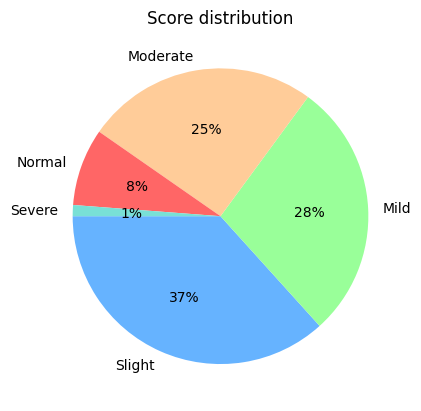

In [ ]:
score_counts = Final_clinical_data_graphical["UPDRS_Score"].value_counts()
score_counts
labels = ['Slight', 'Mild', 'Moderate', 'Normal', 'Severe']
plt.pie(score_counts, autopct='%1.0f%%',labels=labels, startangle=180, colors=['#66b3ff','#99ff99','#ffcc99','#ff6666', '#79e0d6'])
plt.title('Score distribution')
 
plt.show()

In [ ]:
# UPDRS Range values for each range 

Final_clinical_data_graphical['UPDRS_Score'].value_counts()

UPDRS_Score
0    91
2    70
1    63
3    21
4     3
Name: count, dtype: int64

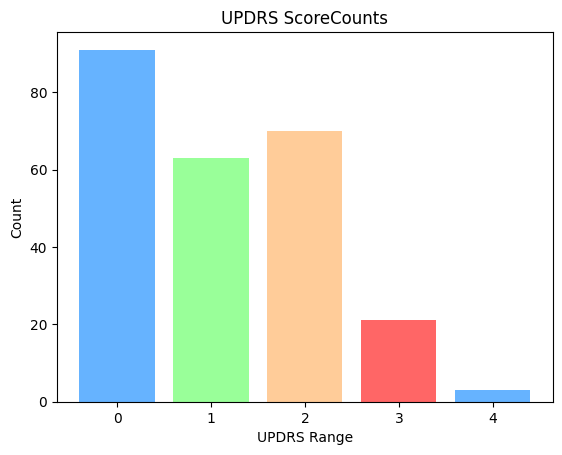

In [ ]:
# Graphical representtaion of UPDRS_Score count.

Score_counts = Final_clinical_data_graphical['UPDRS_Score'].value_counts().sort_index()

# Plotting
plt.bar(Score_counts.index, Score_counts.values, color=['#66b3ff', '#99ff99', '#ffcc99', '#ff6666'])
plt.xlabel('UPDRS Range')
plt.ylabel('Count')
plt.title('UPDRS ScoreCounts')
#plt.xticks(range_counts.index, range_counts.index)

plt.show()



So for the next step we're going to choose a patient for each score categorie and visualize their different updrs levels and their UPDRS Total

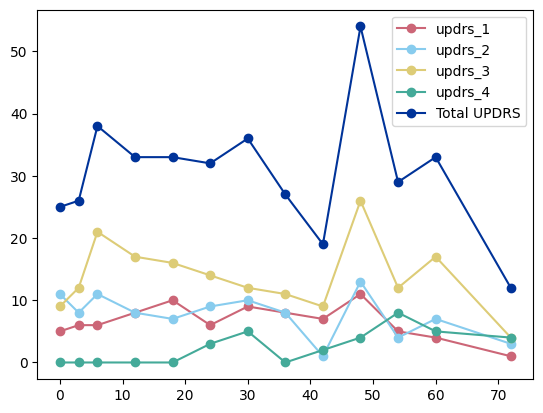

In [ ]:
# Fetch data for a randomly chosen patient with id from categroy 0, patient : 6211		


plot_df = Final_clinical_data[Final_clinical_data["patient_id"]==6211]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()


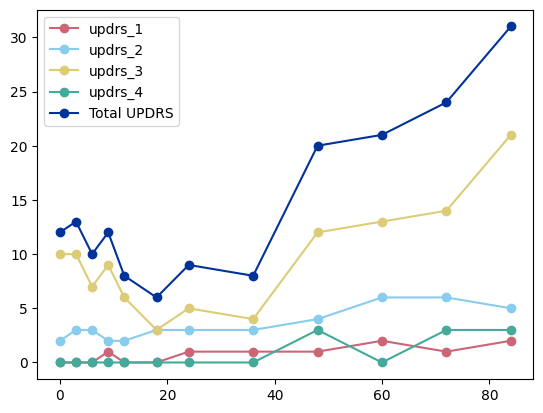

In [ ]:
# Fetch data for a randomly chosen patient with id from categroy 1, patient : 62792

plot_df = Final_clinical_data[Final_clinical_data["patient_id"]==62792]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()

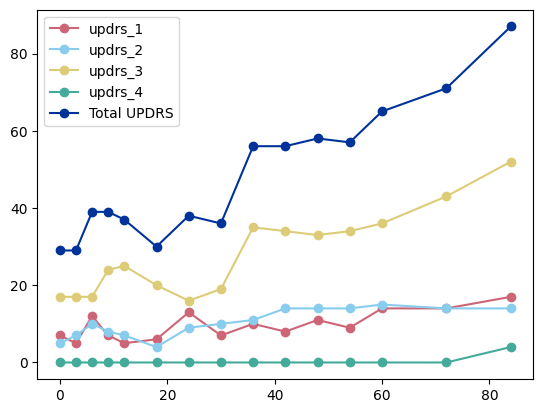

In [ ]:

# Fetch data for a randomly chosen patient with id from categroy 2, patient : 6054

plot_df = Final_clinical_data[Final_clinical_data["patient_id"]==6054]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()

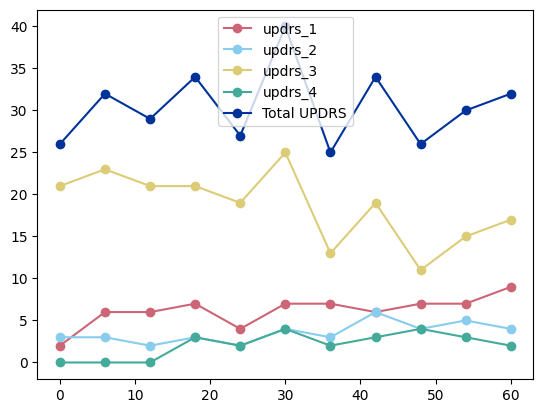

In [ ]:
# Fetch data for a randomly chosen patient with id from categroy 3, patient : 4923	


plot_df = Final_clinical_data[Final_clinical_data["patient_id"]==4923]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()


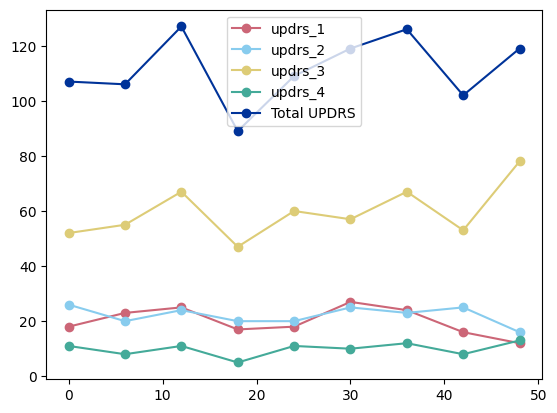

In [ ]:
# Fetch data for a randomly chosen patient with id from categroy 4, patient : 40650


plot_df = Final_clinical_data[Final_clinical_data["patient_id"]== 40650]
fig, ax = plt.subplots(1, 1)

ax.plot(plot_df['visit_month'], plot_df['updrs_1'], marker='o', color="#CC6677", label="updrs_1", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_2'], marker='o', color="#88CCEE", label="updrs_2", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_3'], marker='o', color="#DDCC77", label="updrs_3", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['updrs_4'], marker='o', color="#44AA99", label="updrs_4", linestyle="-")
ax.plot(plot_df['visit_month'], plot_df['Total_UPDRS'], marker='o', color="#003399", label="Total UPDRS", linestyle="-")


ax.legend()
plt.show()


After individually analyzing five distinct patients, a recurring trend emerged where UPDRS3 consistently exhibited the highest scores among updrs_1, updrs_2, updrs_3, and updrs_4. This trend, observed across multiple patients, suggests that UPDRS3 might be a prominent contributing factor influencing the severity of Parkinson's disease symptoms for these individuals

### 2 - Stastical studies and observations 

/var/folders/hs/v7ghmw855pndd96dtpr2vspm0000gn/T/ipykernel_2492/691074247.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Peptides['PeptideAbundance'], fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})


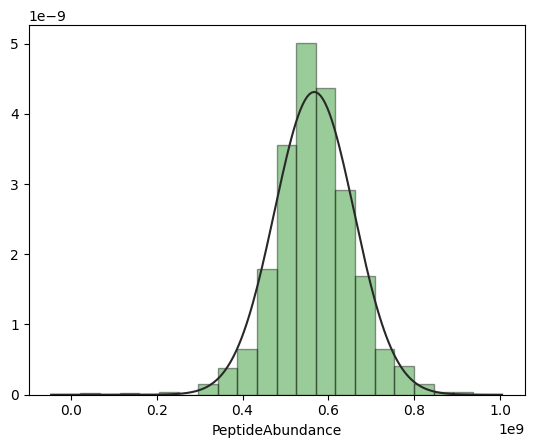

In [ ]:

# Plotting the distribution of 'PeptideAbundance'

sns.distplot(Peptides['PeptideAbundance'], fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})
plt.show()


/var/folders/hs/v7ghmw855pndd96dtpr2vspm0000gn/T/ipykernel_2492/1305690641.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Proteins['NPX'], fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})


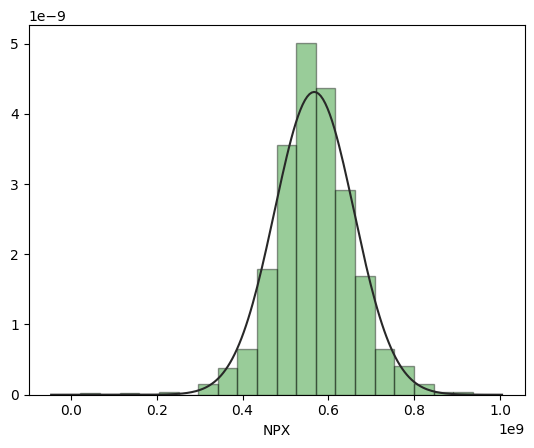

In [ ]:
# Plotting the distribution of 'NPX' (same graph as above)

sns.distplot(Proteins['NPX'], fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})
plt.show()

In [ ]:
## Same result using SPSS 

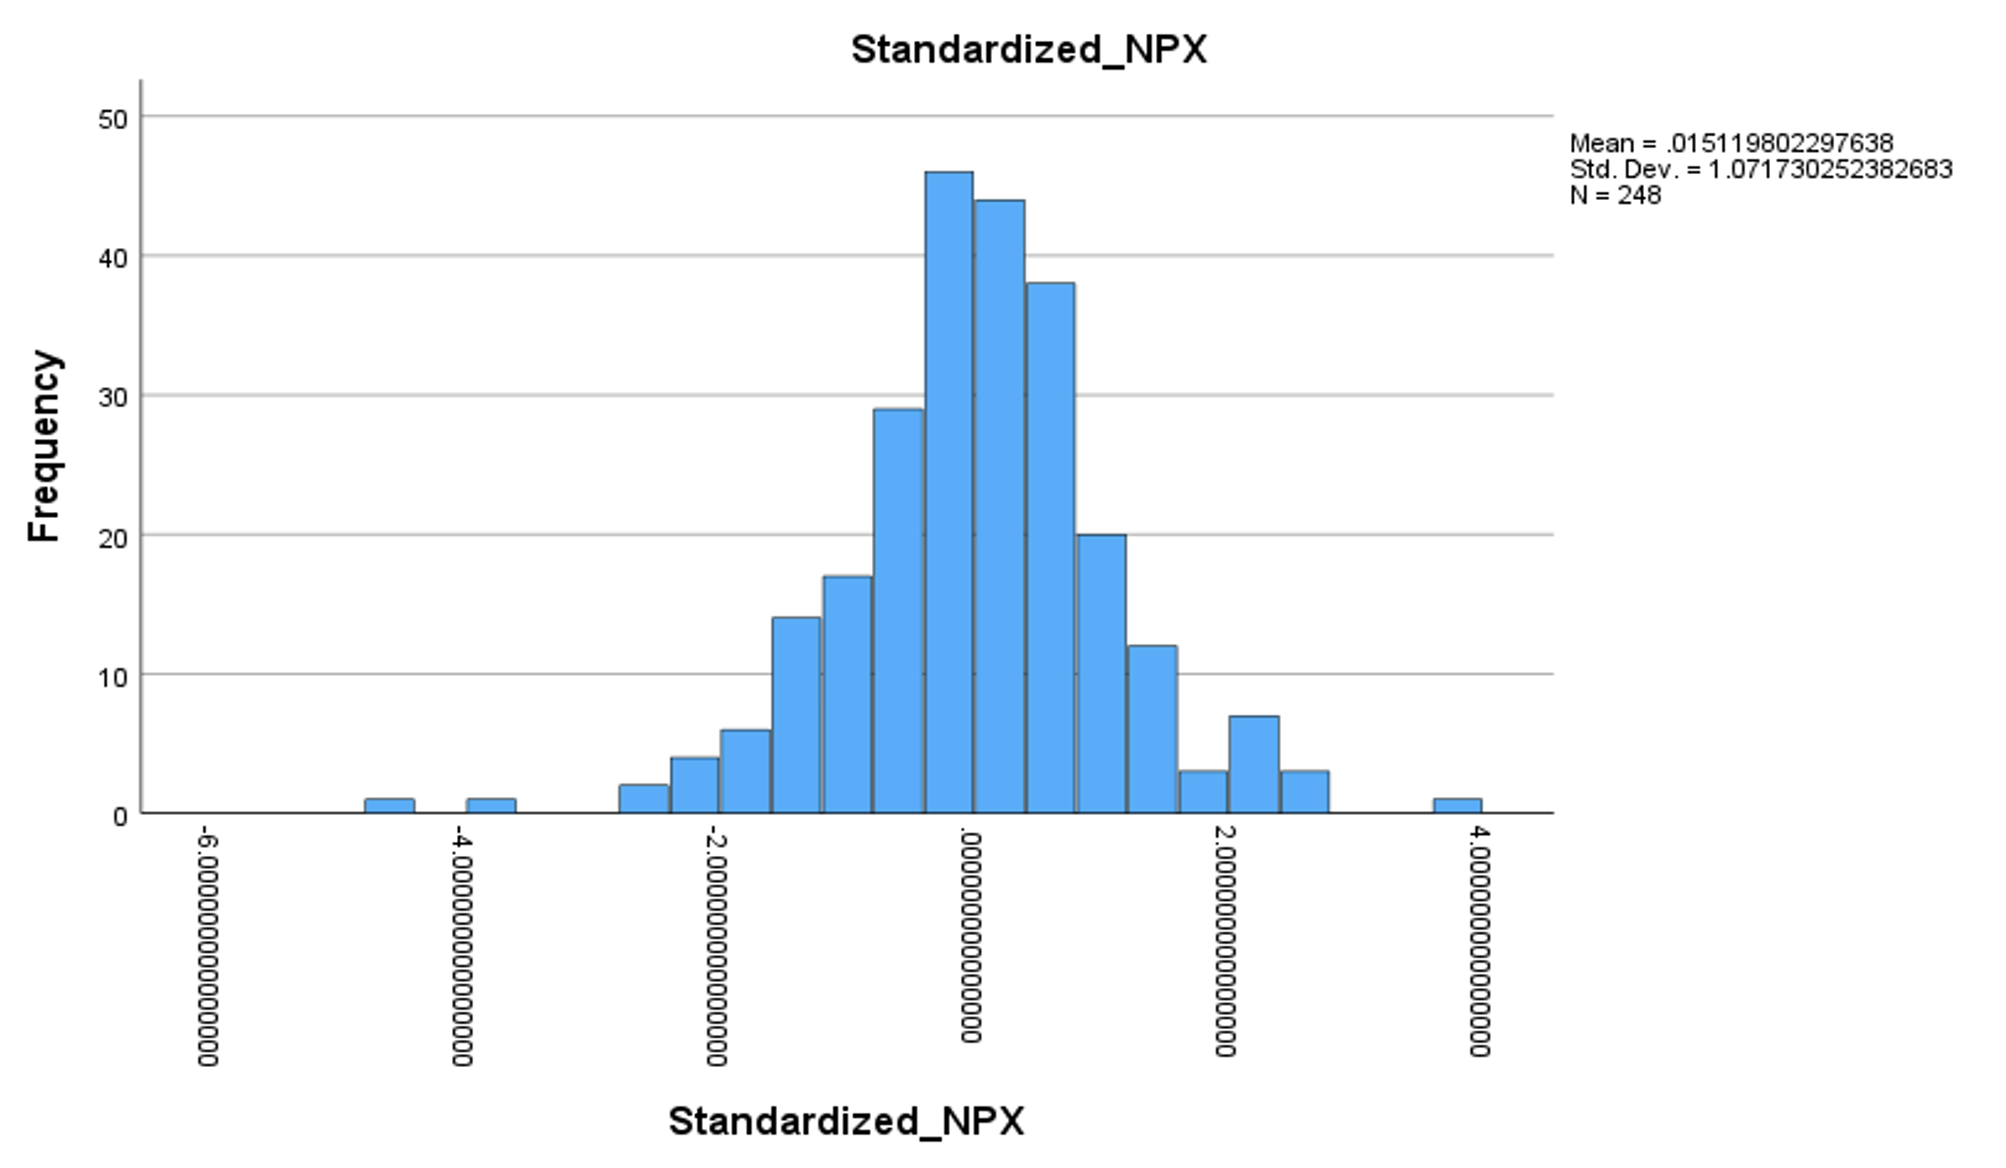

In summary, we can see that our standardized NPX values of our patients have the higher frequency close to 0. This suggests that a significant portion of the original NPX values were clustered around the mean of the distribution.

In [ ]:
## SPSSS

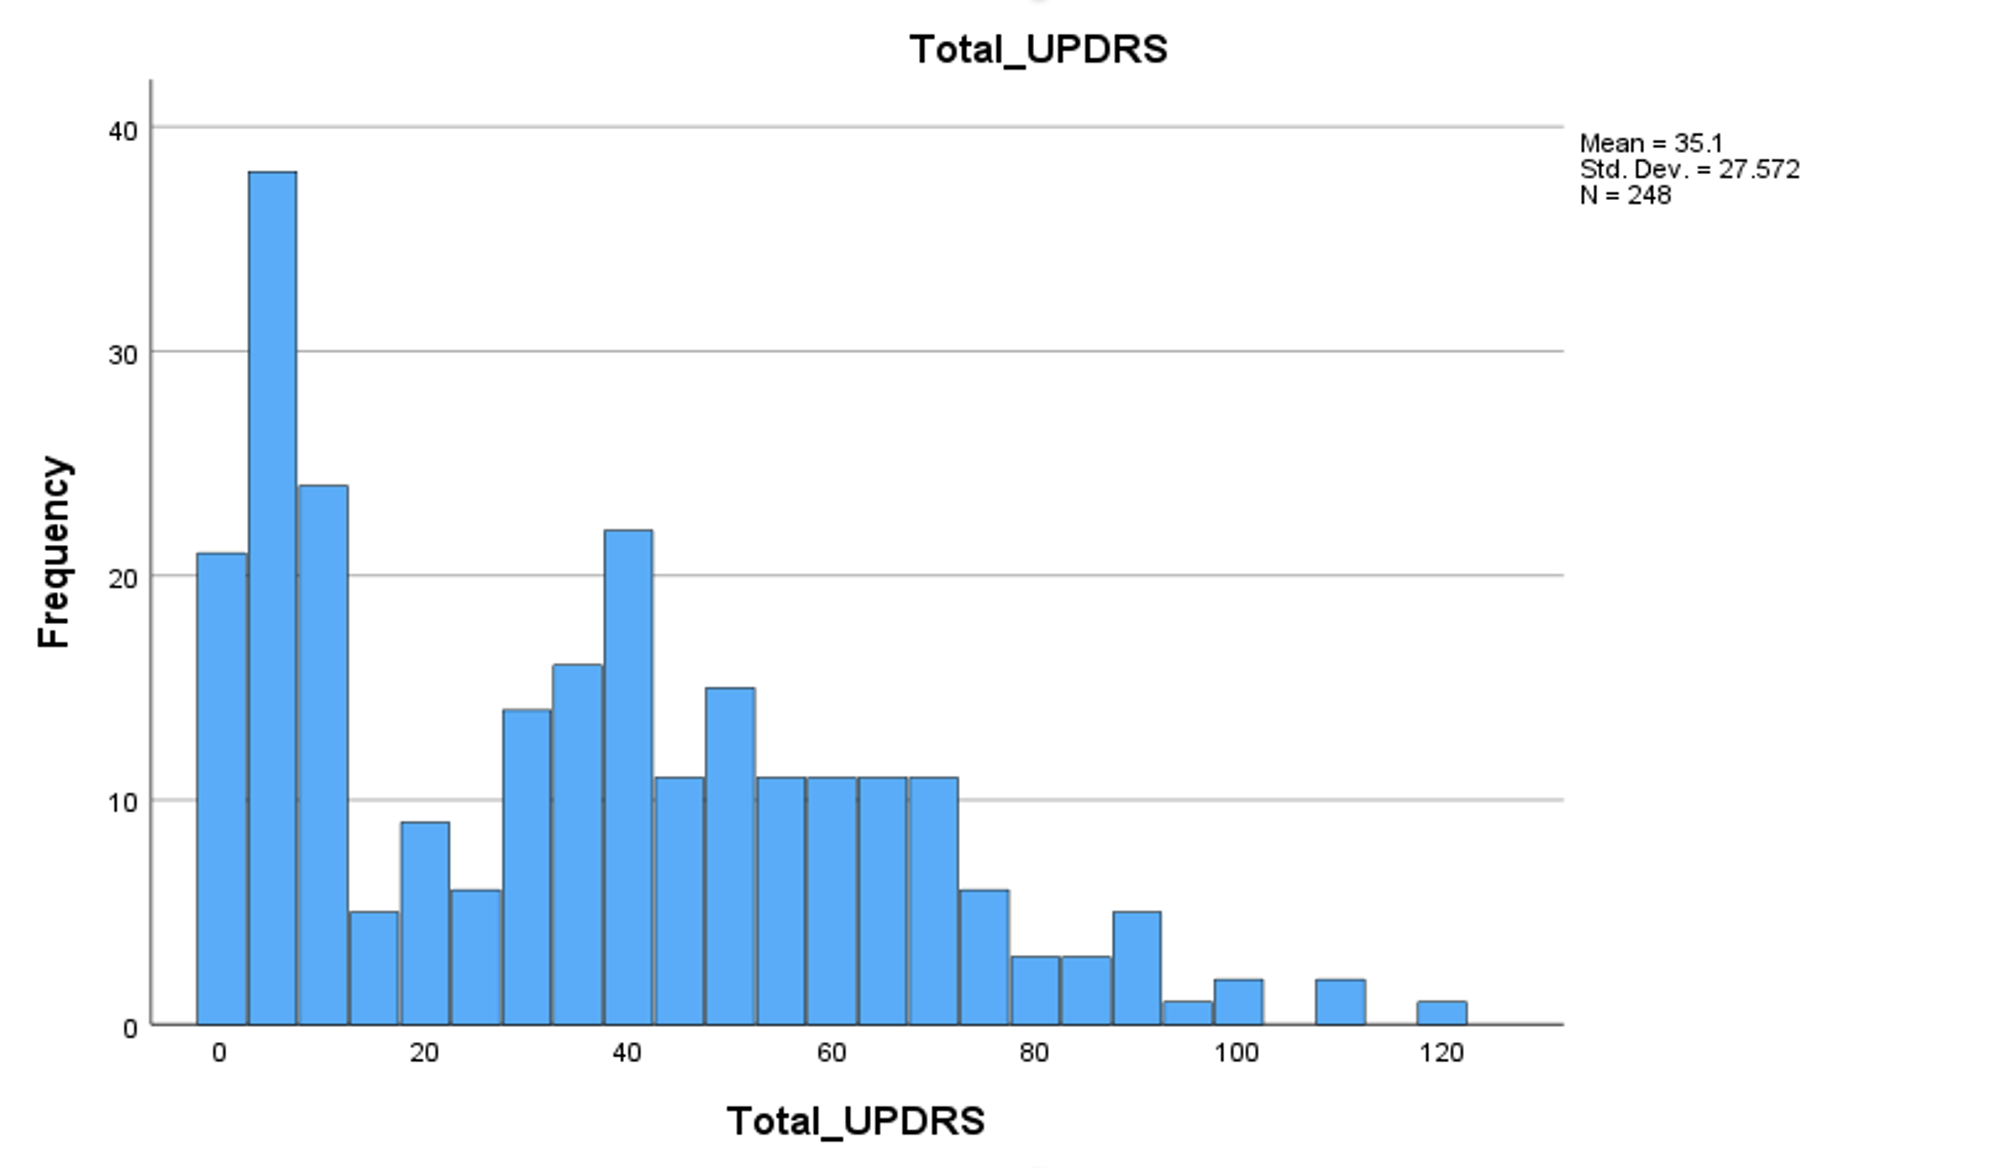

The histogram shown above illustrates the distribution of total UPDRS scores, revealing a higher frequency of occurrences in the lower score range. This concentration of data points in the lower values suggests that a significant portion of the patients in their last visit experiences milder symptoms, as reflected by lower total UPDRS scores.

/var/folders/hs/v7ghmw855pndd96dtpr2vspm0000gn/T/ipykernel_2492/834502578.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(UPDRS, fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})


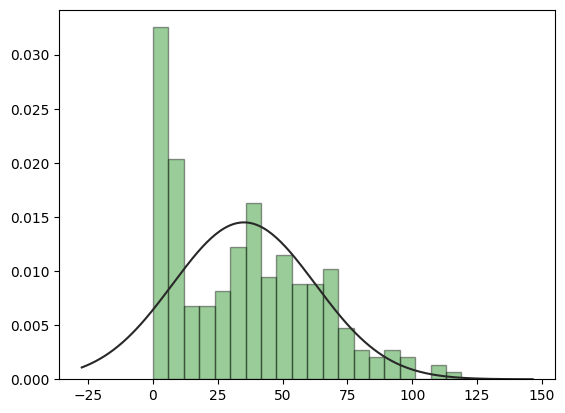

In [ ]:
# Sames as SPSS but using code 
# Plotting the distribution of 'Total_UPDRS'

sns.distplot(UPDRS, fit=norm, kde=False, bins=20, color='g', hist_kws={'edgecolor':'black'})
plt.show()


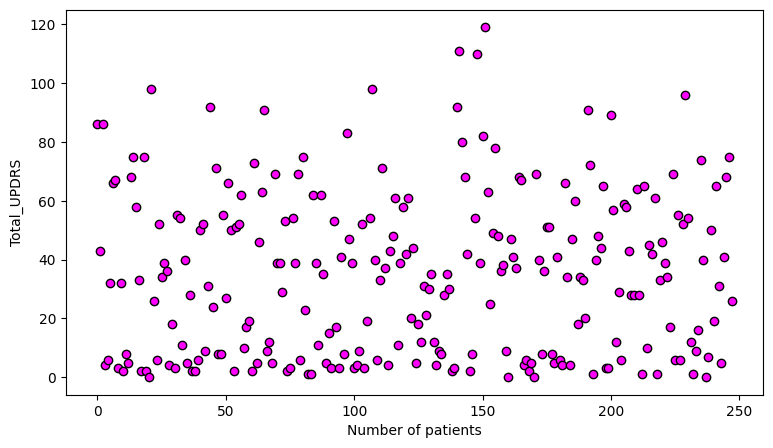

In [ ]:

#creating a numpy array with our patients (instead of having unrognized numbers assigend to each patient we are rescaling from 1 to 562)

Patients = list(range(0,len(UPDRS)))
# Graphical representtaion of Total_UPDRS.
plt.figure(figsize=(9, 5))
plt.scatter(Patients, UPDRS, color='magenta', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('Total_UPDRS')
plt.show()

Text(0, 0.5, 'updrs_1')

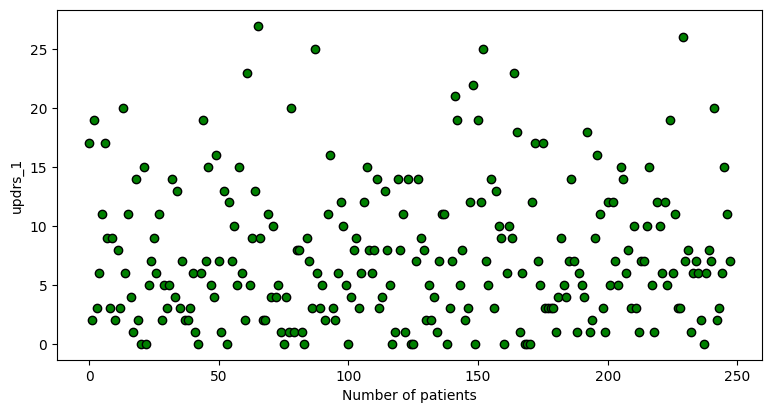

In [ ]:
# Graphical representtaion of UPDRS_1.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_1'], color='g', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_1')

Varies between 0 and 35

Text(0, 0.5, 'updrs_2')

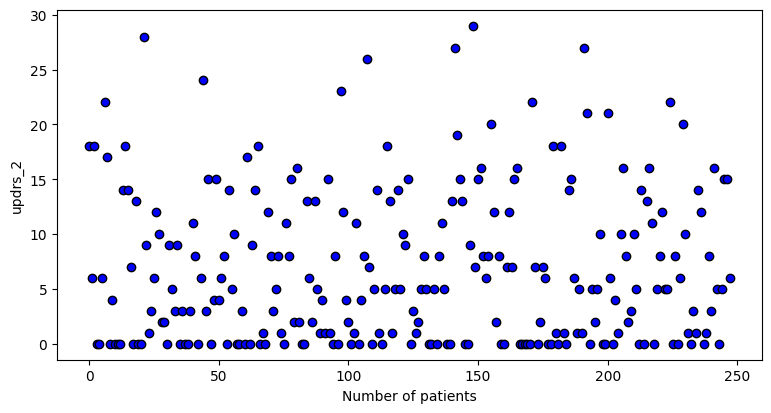

In [ ]:
# Graphical representtaion of UPDRS_2.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 2)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_2'], color='b', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_2')

Varies between 0 and 42

Text(0, 0.5, 'updrs_3')

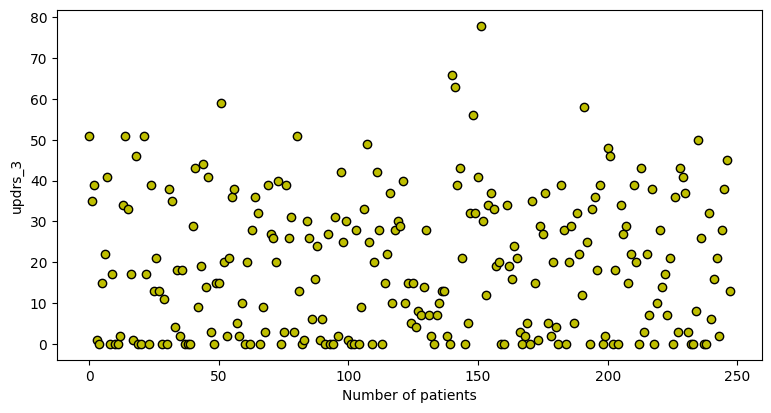

In [ ]:
# Graphical representtaion of UPDRS_3.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 3)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_3'], color='y', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_3')

Varies between 0 and 85

Text(0, 0.5, 'updrs_4')

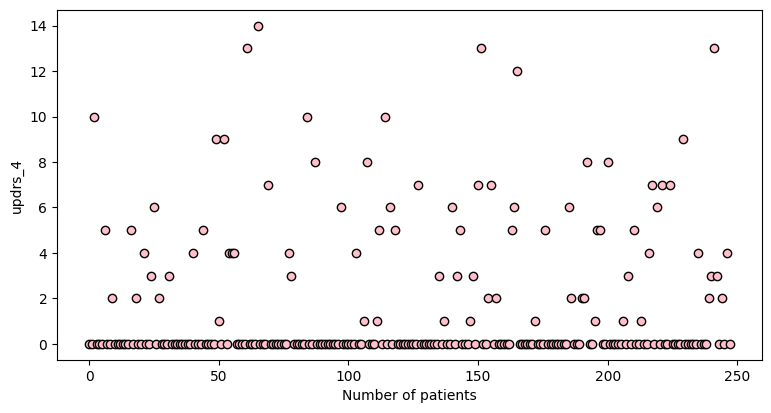

In [ ]:
# Graphical representtaion of UPDRS_4.

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 4)
plt.scatter(Patients, Final_clinical_data_graphical['updrs_4'], color='pink', edgecolors='black')
plt.xlabel('Number of patients')
plt.ylabel('updrs_4')

Varies between 0 and 18

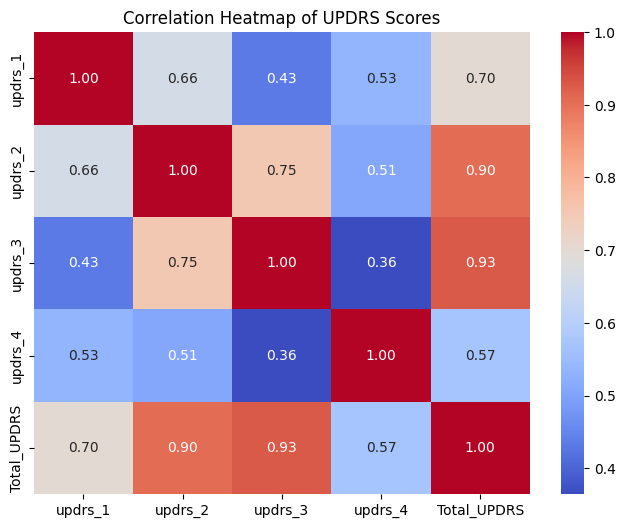

In [ ]:

updrs_subset = Final_clinical_data_graphical[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'Total_UPDRS']]

correlation_matrix = updrs_subset.corr()

# Creating the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of UPDRS Scores')
plt.show()


updrs_2 and updrs_3 seem to be highly correlated with Total_UPDRS, which makes sense since they have the highest upper bound ranged compared to updrs_1 and updrs_2

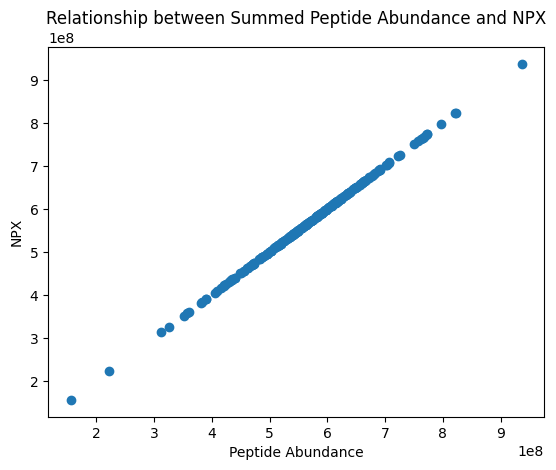

In [ ]:

plt.scatter(Final_clinical_data_graphical['PeptideAbundance'], Final_clinical_data_graphical['NPX'])
plt.xlabel('Peptide Abundance')
plt.ylabel('NPX')
plt.title('Relationship between Summed Peptide Abundance and NPX')
plt.show()


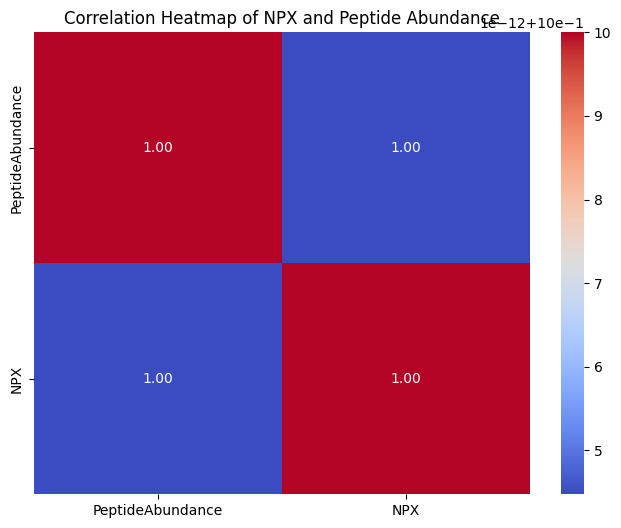

In [ ]:

NPX_Pepetide_Ab = Final_clinical_data_graphical[['PeptideAbundance', 'NPX']]

correlation_matrix2 = NPX_Pepetide_Ab.corr()

# Creating the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of NPX and Peptide Abundance')
plt.show()


There is a very strong relationship between NPX and the summed Peptide abundance for each patient.Given the strong correlation we might consider using either NPX or Peptide Abundance for our machine learning model as they seem to capture similar infformation

# III - Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score



Working with Total_UPDRS as the depndent variables and the rest of the fatures as independent variables

In [ ]:
Final_ML = Final_clinical_data_graphical.drop(['PeptideAbundance','patient_id','visit_month', 'visit_id', 'Standardized_NPX', 'UPDRS_Score', 'Peptide Abundance Standardized'] , axis=1) 
# dropping Peptide Abundnace because it's has a perfect correelation with NPX better drop it for machine learning
Final_ML.head()


,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,clinical_state_on_medication,Total_UPDRS,NPX
3,17.0,18.0,51.0,0.0,0,On,86.0,7.649231e+08
7,2.0,6.0,35.0,0.0,0,Off,43.0,5.979835e+08
11,19.0,18.0,39.0,10.0,0,Off,86.0,5.840639e+08
14,3.0,0.0,1.0,0.0,1,Unknown,4.0,7.711963e+08
18,6.0,0.0,0.0,0.0,1,Unknown,6.0,6.153522e+08


Next step would be that we have to transform thr clinical_state_on _medication values to dummies. 

In [ ]:
Final_ML_dummies = pd.get_dummies(Final_ML, columns=['clinical_state_on_medication'], prefix='clinical_state')

In [ ]:
Final_ML_dummies = Final_ML_dummies.astype(int)
Final_ML_dummies.head()

,updrs_1,updrs_2,updrs_3,updrs_4,updrs_4_missing,Total_UPDRS,NPX,clinical_state_Off,clinical_state_On,clinical_state_Unknown
3,17,18,51,0,0,86,764923056,0,1,0
7,2,6,35,0,0,43,597983523,1,0,0
11,19,18,39,10,0,86,584063932,1,0,0
14,3,0,1,0,1,4,771196270,0,0,1
18,6,0,0,0,1,6,615352184,0,0,1


### 1 - Logistic Regression

In [ ]:
Final_ML_dummies.shape
Final_ML.isnull().sum()
Final_ML_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 3 to 1067
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   updrs_1                 248 non-null    int64
 1   updrs_2                 248 non-null    int64
 2   updrs_3                 248 non-null    int64
 3   updrs_4                 248 non-null    int64
 4   updrs_4_missing         248 non-null    int64
 5   Total_UPDRS             248 non-null    int64
 6   NPX                     248 non-null    int64
 7   clinical_state_Off      248 non-null    int64
 8   clinical_state_On       248 non-null    int64
 9   clinical_state_Unknown  248 non-null    int64
dtypes: int64(10)
memory usage: 21.3 KB


In [ ]:
# Defining our Features and targets
X = Final_ML_dummies[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'updrs_4_missing', 'NPX', 'clinical_state_Off', 'clinical_state_On', 'clinical_state_Unknown']]
y = Final_ML_dummies['Total_UPDRS']

In [ ]:
print(X.shape)
print(y.shape)


(248, 9)
(248,)


In [ ]:


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)


In [ ]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)


LogReg = LogisticRegression()
LogReg.fit(X_train,y_train)
y_pred = LogReg.predict(X_test)


In [ ]:
#Cross_Validation 

kf = KFold(n_splits=10, shuffle = True, random_state=3)
cv_results = cross_val_score(LogReg, X_train, y_train, cv=kf)
print(cv_results)

[0.05263158 0.05263158 0.         0.         0.05263158 0.05263158
 0.         0.         0.11111111 0.        ]


So the best KFold within our cross validation gives us an 0.111 accuracy which is about 11% model accuracy whhich is not Good at all 

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error



mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 1612.8064516129032
Root Mean Squared Error: 40.15976159805861
Mean Absolute Error: 31.096774193548388


In [ ]:

def calculate_smape(y_true, ppred):
    denominator = (np.abs(y_true) + np.abs(ppred))
    division = np.where(denominator == 0, 0, (np.abs(y_true - ppred) / denominator))
    smape = (200 * np.mean(division))
    return smape

# Calculate sMAPE
smape = calculate_smape(y_test, y_pred)
print("sMAPE:", smape)


sMAPE: 147.8933858837701


In [ ]:
# Trying to improve introducing Lasso l1 and Rigid l2 

In [ ]:

# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Feature scaling
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

# Applying Logistic Regression with L1 (Lasso) regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=3, max_iter=2000)
logreg_l1.fit(X1_train, y1_train)
y_pred_l1 = logreg_l1.predict(X1_test)

# Cross-validation with L1
kf = KFold(n_splits=10, shuffle=True, random_state=3)
cv_results_l1 = cross_val_score(logreg_l1, X, y, cv=kf)
print("Cross-validation results with L1 regularization:", cv_results_l1.mean())

# Applying Logistic Regression with L2 (Ridge) regularization
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', random_state=3, max_iter=2000)
logreg_l2.fit(X1_train, y1_train)
y_pred_l2 = logreg_l2.predict(X1_test)

# Cross-validation with L2
cv_results_l2 = cross_val_score(logreg_l2, X, y, cv=kf)
print("Cross-validation results with L2 regularization:", cv_results_l2.mean())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross-validation results with L1 regularization: 0.09666666666666666
Cross-validation results with L2 regularization: 0.024166666666666666


We can't seem to reduce the convergence of l1 and l2 there are two possible solutions we can either reduce the number of features or change the solver we are working with for one that is mor custom to a large set of features 

##### changing Solver

In [ ]:

# Train-test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Feature scaling
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

# Applying Logistic Regression with L1 (Lasso) regularization
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', random_state=3, max_iter=2000)
logreg_l1.fit(X1_train, y1_train)
y_pred_l1 = logreg_l1.predict(X1_test)

# Cross-validation with L1
kf = KFold(n_splits=10, shuffle=True, random_state=3)
cv_results_l1 = cross_val_score(logreg_l1, X, y, cv=kf)
print("Cross-validation results with L1 regularization:", cv_results_l1.mean())

# Applying Logistic Regression with L2 (Ridge) regularization
logreg_l2 = LogisticRegression(penalty='l2', solver='saga', random_state=3, max_iter=2000)
logreg_l2.fit(X1_train, y1_train)
y_pred_l2 = logreg_l2.predict(X1_test)

# Cross-validation with L2
cv_results_l2 = cross_val_score(logreg_l2, X, y, cv=kf)
print("Cross-validation results with L2 regularization:", cv_results_l2.mean())


Cross-validation results with L1 regularization: 0.024166666666666666
Cross-validation results with L2 regularization: 0.024166666666666666


Still not workiing we might have to consider using less features and test with other models

In [ ]:
Xless=  Final_ML_dummies[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'NPX']]

### 2- Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Spliting the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=3)

# Define the parameter grid to search through
param_grid = {
    'max_depth': [3, 5, 7, 10, 12, 15, 18, 20],    # Different max depth values to try
    'min_samples_leaf': [1, 2, 4, 6]               # Different min samples leaf values to try
}

# Creating a decision tree classifier
dt_regressor = DecisionTreeRegressor(random_state=3)

# Using GridSearchCV for cross-validation and parameter tuning
grid_search = GridSearchCV(dt_regressor, param_grid, cv=5, scoring ='r2')
grid_search.fit(X_train, y_train)

# Getting the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

#predicting 
ypred = best_estimator.predict(X_test)



In [ ]:
mse = mean_squared_error(ytest, ypred)
rmse = mean_squared_error(ytest, ypred, squared=False)
mae = mean_absolute_error(ytest, ypred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 50.145161290322584
Root Mean Squared Error: 7.081324825929297
Mean Absolute Error: 4.629032258064516


In [ ]:

# Calculate sMAPE
smape = calculate_smape(ytest, ypred)
print("sMAPE:", smape)

sMAPE: 17.02508874443237


In [ ]:
r2 = r2_score(ytest, ypred)
print(f"R^2 for Decision Tree: {r2:.4f}")

R^2 for Decision Tree: 0.9238


### 3- Random Forest

In [ ]:

X = Final_ML_dummies[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_3', 'updrs_4', 'updrs_4_missing', 'NPX', 'clinical_state_Off', 'clinical_state_On', 'clinical_state_Unknown']]
y = Final_ML_dummies['Total_UPDRS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=3)

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters with SMAPE metric
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_estimator.predict(X_test_scaled)

# Evaluate the model's performance using SMAPE
smape = calculate_smape(y_test, y_pred)
print("Best Parameters:", best_params)
print("SMAPE:", smape)



Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
SMAPE: 11.939714010824364


In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 14.60922580645162
Root Mean Squared Error: 3.8222016962022844
Mean Absolute Error: 2.2109677419354847


In [ ]:
r2_dt = r2_score(y_test, y_pred)
print(f"R^2 for Decision Tree: {r2_dt:.4f}")

R^2 for Decision Tree: 0.9778


Testing Random forest with less features : 

In [ ]:

# Split the data into training and testing sets
X_train, X_test, train, test = train_test_split(Xless, y, test_size=0.25, random_state=3)

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=3)

# Define the parameter grid for hyperparameter optimization
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best hyperparameters with SMAPE metric
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5)
grid_search.fit(X_train_scaled, train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions on the test set
pred = best_estimator.predict(X_test_scaled)

# Evaluate the model's performance using SMAPE
smape = calculate_smape(test, pred)
print("Best Parameters:", best_params)
print("SMAPE:", smape)



Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
SMAPE: 11.542175806853951


In [ ]:
mse = mean_squared_error(test, pred)
rmse = mean_squared_error(test, pred, squared=False)
mae = mean_absolute_error(test, pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 13.610910291402693
Root Mean Squared Error: 3.689296720433678
Mean Absolute Error: 2.02126918959177


In [ ]:
r2_t = r2_score(test, pred)
print(f"R^2 for Decision Tree: {r2_t:.4f}")

R^2 for Decision Tree: 0.9793


Random forest with less features offers a slightly more accurate sMAPE

### 4 - K-Mean clustering

In [ ]:
from sklearn.cluster import KMeans

df_for_kmeans= Final_clinical_data_graphical[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4', 'NPX', 'updrs_4_missing']]
df_for_kmeans




,updrs_1,updrs_2,updrs_3,updrs_4,NPX,updrs_4_missing
3,17.0,18.0,51.0,0.0,7.649231e+08,0
7,2.0,6.0,35.0,0.0,5.979835e+08,0
11,19.0,18.0,39.0,10.0,5.840639e+08,0
14,3.0,0.0,1.0,0.0,7.711963e+08,1
18,6.0,0.0,0.0,0.0,6.153522e+08,1
...,...,...,...,...,...,...
1046,3.0,0.0,2.0,0.0,5.435102e+08,0
1052,6.0,5.0,28.0,2.0,5.450832e+08,0
1057,15.0,15.0,38.0,0.0,5.587043e+08,0
1063,11.0,15.0,45.0,4.0,4.292280e+08,0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

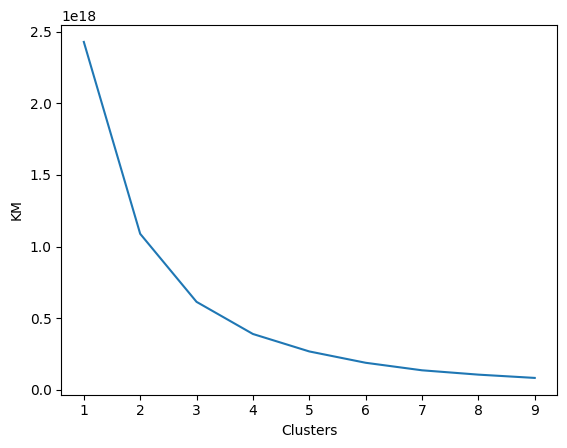

In [ ]:
#in order to identify optimal number of clusters, we have applied a distortion method algorithm which based on dataset returns a optimal number of clusters
#The model suggested that 3 is the best fit for cluters, apart from that, it is known that it has more efficiency if the number of clusters won't exceed n=5


elbow = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state =3)
    kmeanModel.fit(df_for_kmeans)
    elbow.append(kmeanModel.inertia_)

plt.plot(np.arange(1,10),elbow)
plt.xlabel('Clusters')
plt.ylabel('KM')
plt.show()

Best number of cluster is either 3 or 4, cause we can still see a small angle/deviation at 4

In [ ]:
km_sample = KMeans(n_clusters=3)
km_sample.fit(df_for_kmeans)

df_for_kmeans['clusters'] = km_sample.fit_predict(df_for_kmeans)
centroids = km_sample.cluster_centers_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/hs/v7ghmw855pndd96dtpr2vspm0000gn/T/ipykernel_2492/3079145898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fo

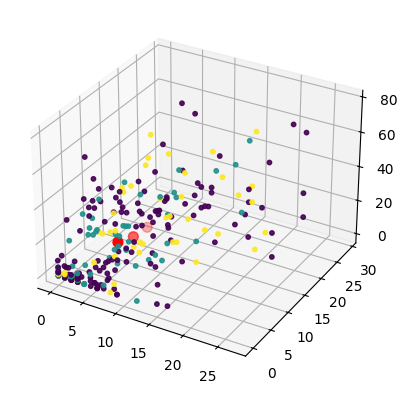

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_for_kmeans['updrs_1'], df_for_kmeans['updrs_2'], df_for_kmeans['updrs_3'], c=km_sample.labels_.astype(int), s=10, alpha=0.9)

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=50)

plt.show()
